In [1]:
!unzip 'hw4.zip'

Archive:  hw4.zip
  inflating: HW4.tex                 
  inflating: backprop_example1.txt   
  inflating: backprop_example2.txt   
   creating: datasets/
  inflating: datasets/hw3_cancer.csv  
  inflating: datasets/hw3_house_votes_84.csv  
  inflating: datasets/hw3_wine.csv   
   creating: figures/
  inflating: figures/.DS_Store       
  inflating: figures/network_example.pdf  


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [3]:
class NN:
    def __init__(self, sizes, initial_weights=None, eta=0.01, reg_lambda=0.01, use_softmax=False):
        self.sizes = sizes
        self.eta = eta
        self.reg_lambda = reg_lambda
        self.use_softmax = use_softmax
        self.weights = self.init_weights() if initial_weights is None else initial_weights

    def init_weights(self):
        return [np.random.randn(y, x + 1) * 0.1 for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def add_bias(self, X):
        return np.insert(X, 0, 1, axis=1)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        act = [self.add_bias(X)]
        ll = []
        for index, weight in enumerate(self.weights[:-1]):
            ll.append(act[-1] @ weight.T)
            act.append(self.add_bias(1 / (1 + np.exp(-ll[-1]))))
        ll.append(act[-1] @ self.weights[-1].T)
        act.append(self.softmax(ll[-1]) if self.use_softmax else 1 / (1 + np.exp(-ll[-1])))
        return act, ll

    def cost(self, Y, act):
        xq = Y.shape[0]
        return -np.sum(Y * np.log(act[-1] + 1e-8)) / xq if self.use_softmax else -np.sum(Y * np.log(act[-1]) + (1 - Y) * np.log(1 - act[-1])) / xq

    def backward(self, targets, activations, weights):
        num_samples = targets.shape[0]
        errors = [activations[-1] - targets]
        gradients = []
        for i in range(len(weights) - 1, 0, -1):
            delta = (errors[0] @ weights[i][:, 1:]) * activations[i][:, 1:] * (1 - activations[i][:, 1:])
            errors.insert(0, delta)
        for i in range(len(weights)):
            grad = errors[i].T @ activations[i] / num_samples
            gradients.append(grad)
        return errors, gradients

    def update_weights(self, gradients):
        for i in range(len(self.weights)):
            regularization_grad = (self.reg_lambda * self.weights[i]) / self.weights[i].shape[0]
            regularization_grad[:, 0] = 0
            self.weights[i] -= self.eta * (gradients[i] + regularization_grad)

    def predict(self, inputs):
        final_activations, _ = self.forward(inputs)
        return np.argmax(final_activations[-1], axis=1) + 1

    def train(self, inputs, labels, iterations):
        for _ in range(iterations):
            final_activations, _ = self.forward(inputs)
            _, weight_gradients = self.backward(labels, final_activations, self.weights)
            self.update_weights(weight_gradients)
        return self.weights


# Breast Cancer Dataset

The goal, here,
is to classify whether tissue removed via a biopsy indicates whether a person may or may not have breast
cancer. There are 699 instances in this dataset. Each instance is described by 9 numerical attributes, and
there are 2 classes

In [5]:
cancer_dataset = pd.read_csv('datasets/hw3_cancer.csv', delimiter='\t')
cancer_dataset = cancer_dataset.sample(frac=1, random_state=42)
cancer_features = cancer_dataset.drop('Class', axis=1)
cancer_labels = cancer_dataset['Class']
scaler = StandardScaler()
cancer_features_scaled = scaler.fit_transform(cancer_features)
encoder = OneHotEncoder(sparse=False)
cancer_labels_encoded = encoder.fit_transform(cancer_labels.to_numpy().reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(cancer_features_scaled, cancer_labels_encoded, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [6]:
def accuracy(Y, predictions):
    true_labels = np.argmax(Y, axis=1) + 1
    accuracy = np.mean(predictions == true_labels)
    return accuracy * 100

def f1_score(Y, predictions):
    true_labels = np.argmax(Y, axis=1) + 1
    classes = np.unique(true_labels)
    f1_scores = []
    for c in classes:
        tp = np.sum((predictions == c) & (true_labels == c))
        fp = np.sum((predictions == c) & (true_labels != c))
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        fn = np.sum((predictions != c) & (true_labels == c))
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)
    avg_f1 = np.mean(f1_scores) * 100
    return avg_f1

def stratified_cross_validation(features, labels, k=10):
    label_indices = [np.where(labels == label)[0] for label in np.unique(labels)]
    folds = []
    pairs = []
    shuffled_label_indices = [np.random.permutation(label_list) for label_list in label_indices]
    label_splits = [np.array_split(label_list, k) for label_list in shuffled_label_indices]
    for fold_parts in zip(*label_splits):
        fold = np.concatenate(fold_parts)
        folds.append(fold)
    for fold_index in range(k):
        test_fold = folds[fold_index]
        train_fold = np.concatenate([folds[i] for i in range(k) if i != fold_index])
        pairs.append((train_fold, test_fold))
    return pairs

In [7]:
nn = NN([9, 4, 8, 2], use_softmax=True)
trained_weights = nn.train(X_train, y_train, iterations=20000)
train_predictions = nn.predict(X_train)
train_accuracy = accuracy(y_train, train_predictions)
print(f"Training Accuracy: {train_accuracy:.2f}%")
test_predictions = nn.predict(X_test)
test_accuracy = accuracy(y_test, test_predictions)
print(f"Testing Accuracy: {test_accuracy:.2f}%")

Training Accuracy: 97.14%
Testing Accuracy: 95.71%


In [8]:
structures = [
    ([9, 8, 2], 0.01, 0.05),
    ([9, 8, 2], 0.01, 0.1),
    ([9, 16, 2], 0.05, 0.05),
    ([9, 16, 2], 0.05, 0.1),
    ([9, 4, 4, 4, 2], 0.1, 0.05),
    ([9, 4, 4, 4, 2], 0.1, 0.1),
    ([9, 8, 8, 8, 2], 0.05, 0.05),
    ([9, 8, 8, 8, 2], 0.05, 0.1),
    ([9, 16, 16, 16, 2], 0.01, 0.05),
    ([9, 16, 16, 16, 2], 0.01, 0.1),
    ([9, 32, 32, 32, 32, 2], 0.05, 0.05),
    ([9, 32, 32, 32, 32, 2], 0.05, 0.5)
]
results = []
label_classes = np.argmax(cancer_labels_encoded, axis=1)
for config, lambda_reg, learning_rate in structures:
    train_accuracies = []
    train_f1_scores = []
    test_accuracies = []
    test_f1_scores = []
    splits = stratified_cross_validation(cancer_features_scaled, label_classes, k=10)
    for train_indices, test_indices in splits:
        X_train, y_train = cancer_features_scaled[train_indices], cancer_labels_encoded[train_indices]
        X_test, y_test = cancer_features_scaled[test_indices], cancer_labels_encoded[test_indices]
        nn = NN(config, eta=learning_rate, reg_lambda=lambda_reg, use_softmax=True)
        trained_weights = nn.train(X_train, y_train, iterations=10000)
        train_predictions = nn.predict(X_train)
        train_accuracy = accuracy(y_train, train_predictions)
        train_f1 = f1_score(y_train, train_predictions)
        test_predictions = nn.predict(X_test)
        test_accuracy = accuracy(y_test, test_predictions)
        test_f1 = f1_score(y_test, test_predictions)
        train_accuracies.append(train_accuracy)
        train_f1_scores.append(train_f1)
        test_accuracies.append(test_accuracy)
        test_f1_scores.append(test_f1)
    results.append({
        "configuration": config,
        "lambda": lambda_reg,
        "learning_rate": learning_rate,
        "train_accuracy": np.mean(train_accuracies),
        "train_f1": np.mean(train_f1_scores),
        "test_accuracy": np.mean(test_accuracies),
        "test_f1": np.mean(test_f1_scores)
    })

for result in results:
    print(f"Structure: {result['configuration']}, Lambda: {result['lambda']}, Learning Rate: {result['learning_rate']}, "
          f"Train Acc: {result['train_accuracy']:.2f}, Train F1: {result['train_f1']:.2f}, Test Acc: {result['test_accuracy']:.2f}, "
          f"Test F1: {result['test_f1']:.2f}")


Structure: [9, 8, 2], Lambda: 0.01, Learning Rate: 0.05, Train Acc: 96.68, Train F1: 96.35, Test Acc: 96.14, Test F1: 95.77
Structure: [9, 8, 2], Lambda: 0.01, Learning Rate: 0.1, Train Acc: 96.76, Train F1: 96.43, Test Acc: 96.57, Test F1: 96.23
Structure: [9, 16, 2], Lambda: 0.05, Learning Rate: 0.05, Train Acc: 96.22, Train F1: 95.82, Test Acc: 95.86, Test F1: 95.41
Structure: [9, 16, 2], Lambda: 0.05, Learning Rate: 0.1, Train Acc: 96.22, Train F1: 95.82, Test Acc: 95.71, Test F1: 95.27
Structure: [9, 4, 4, 4, 2], Lambda: 0.1, Learning Rate: 0.05, Train Acc: 65.52, Train F1: 39.59, Test Acc: 65.52, Test F1: 39.58
Structure: [9, 4, 4, 4, 2], Lambda: 0.1, Learning Rate: 0.1, Train Acc: 65.52, Train F1: 39.59, Test Acc: 65.52, Test F1: 39.58
Structure: [9, 8, 8, 8, 2], Lambda: 0.05, Learning Rate: 0.05, Train Acc: 65.52, Train F1: 39.59, Test Acc: 65.52, Test F1: 39.58
Structure: [9, 8, 8, 8, 2], Lambda: 0.05, Learning Rate: 0.1, Train Acc: 65.52, Train F1: 39.59, Test Acc: 65.52, Tes

In [9]:
results_table = pd.DataFrame(results)
results_table = results_table.rename(columns={
    "configuration": "Structure",
    "lambda": "Lambda",
    "learning_rate": "Learning Rate",
    "train_accuracy": "Train Accuracy",
    "train_f1": "Train F1 Score",
    "test_accuracy": "Test Accuracy",
    "test_f1": "Test F1 Score"
})
results_table.sort_values(by=["Lambda", "Learning Rate"], inplace=True)
print(results_table.to_string(index=False))

             Structure  Lambda  Learning Rate  Train Accuracy  Train F1 Score  Test Accuracy  Test F1 Score
             [9, 8, 2]    0.01           0.05       96.677895       96.345827      96.142682      95.769218
    [9, 16, 16, 16, 2]    0.01           0.05       96.693818       96.370927      96.436561      96.104254
             [9, 8, 2]    0.01           0.10       96.757361       96.434512      96.569183      96.230481
    [9, 16, 16, 16, 2]    0.01           0.10       96.868674       96.566712      96.577348      96.250449
            [9, 16, 2]    0.05           0.05       96.216921       95.823350      95.856910      95.411836
       [9, 8, 8, 8, 2]    0.05           0.05       65.522177       39.585132      65.522352      39.584981
[9, 32, 32, 32, 32, 2]    0.05           0.05       65.522177       39.585132      65.522352      39.584981
            [9, 16, 2]    0.05           0.10       96.216845       95.823478      95.713936      95.272831
       [9, 8, 8, 8, 2]    0.

### Vectorized form of backpropagation and forward.

**Question 4** Discuss (on a high level) what contributed the most to improving performance: changing the regularization parameter; adding more layers; having deeper networks with many layers but few neurons per layer? designing networks with few layers but many neurons per layer? Discuss any patterns that you may have encountered. Also, discuss whether there is a point where constructing and training more “sophisticated”/complex networks—i.e., larger networks—no longer improves performance (or worsens performance).

I used number of k=10000 iterations as stopping criterion.

Simpler Architectures like [9, 8, 2] and [9, 16, 2] consistently perform well, achieving high accuracy and F1 scores across different settings. This suggests that for the given dataset, simpler architectures are sufficient to capture the complexity of the data without overfitting.

Moderately Complex Architectures like [9, 16, 16, 16, 2] show a small improvement in performance at higher learning rates 0.10, indicating that with appropriate training, slightly deeper architectures might leverage additional representational power to enhance performance slightly.

Highly Complex Architectures [9, 8, 8, 8, 2] and [9, 32, 32, 32, 32, 2]witness a significant decline in performance, especially with increased depth and number of neurons. This big drop indicates potential training difficulties, such as vanishing gradients, or excessive complexity leading to inefficiencies or overfitting.

Regularization: Increasing the regularization strength to 0.05 generally results in a decrease in performance, particularly for more complex networks. This may suggest that the models are either being overly penalized, hindering their ability to fit the data well, or that the data's complexity does not require strong regularization to prevent overfitting.

A higher learning rate 0.10 tends to improve performance in moderately complex networks, possibly indicating that these networks benefit from faster convergence. However, the adjustment of learning rates does not significantly alter performance outcomes in overly complex or overly simple networks, suggesting that architectural decisions are more critical.

Moderately complex architectures like [9, 16, 16, 16, 2] may offer an optimal balance providing sufficient complexity to learn detailed patterns in the data without the training challenges associated with deeper networks. Very deep networks with many layers [9, 8, 8, 8, 2] and larger underperform compared to simpler architectures. Adding more layers doesn't necessarily translate to better performance and can actually impact results negatively due to increased computational complexity and training difficulty.

There is a clear point where adding more complexity (either through more layers or more neurons per layer) does not yield benefits and begins to negatively impact performance. This is shown with the drop in performance metrics for the most complex architectures tested. It suggests that beyond a certain level of complexity, networks become more challenging to train effectively and more prone to overfitting or failing to converge. The point of diminishing returns appears between the [9, 16, 16, 16, 2] and the more complex [9, 8, 8, 8, 2] or [9, 32, 32, 32, 32, 2] structures. These architectures do not improve and actually degrade performance.

**Question 5** Based on the analyses above, discuss which neural network architecture you would select if you had to deploy such a classifier in real life. Explain your reasoning

Based on the performance data and the analysis of various neural network architectures tested, we're going to discuss what model we would select for real-life deployment.

I would choose [9, 16, 16, 16, 2] since this structure provides a moderate level of complexity that appears to handle the dataset well. It offers multiple layers which enable it to capture more complex patterns and relationships in the data without being as prone to the training difficulties associated with deeper and more complex networks.
It not only performs well in terms of training accuracy and F1 score but also shows good test performance, indicating effective generalization from the training data to unseen data. The balance it has between depth and width allows it to learn nuanced features without fitting noise or irrelevant details. The performance data suggest that this model does not overfit as significantly as more complex models, likely due to an effective balance of depth and regularization. It maintains robustness across different learning rates, which is a good indicator of its stability under various training conditions.

Should the amount of data or the number of features increase over time, this architecture should be capable of scaling up relatively easily. The moderate complexity of this model also eases maintainability since it is less likely to require frequent tuning compared to very complex models. It is not time consuming or requires excessive computational power which is also an important factor in real-world applications where both training time and computational costs need to be optimized to ensure practicality and efficiency. It may require slightly more resources compared to simpler architectures due to its deeper structure, but the increase is justified by significant improvements in performance metrics.
A lambda value of 0.01 and a learning rate of 0.05 or 0.10 seem to be effective based on the performance metrics.




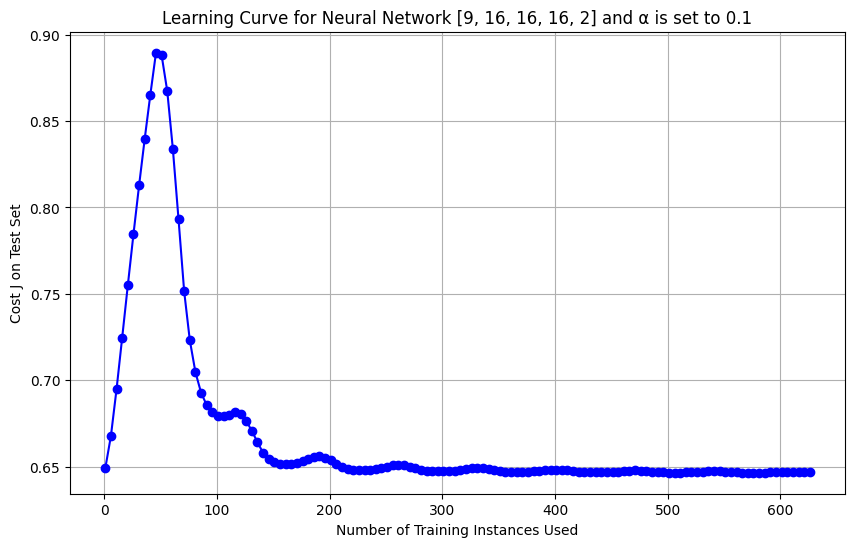

In [13]:
def learning_curve(X_train, y_train, X_test, y_test, nn, increments=5):
    costs = []
    for i in range(1, len(X_train), increments):
        nn.train(X_train[:i], y_train[:i], iterations=1)
        activations, _ = nn.forward(X_test)
        cost = nn.cost(y_test, activations[-1])
        costs.append(cost)
    return costs

np.random.seed(0)
nn = NN([9, 16, 16, 16, 2], eta=0.1, reg_lambda=0.01, use_softmax=True)
costs = learning_curve(X_train, y_train, X_test, y_test, nn)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(X_train), 5), costs, marker='o', linestyle='-', color='b')
plt.title('Learning Curve for Neural Network [9, 16, 16, 16, 2] and α is set to 0.1')
plt.xlabel('Number of Training Instances Used')
plt.ylabel('Cost J on Test Set')
plt.grid(True)
plt.show()

α is set to 0.1